# Exploring Model Explanations Pt 1

In this notebook we demonstrate how to interpret Bert models using Captum library. In this particular case study we focus on  
a fine-tuned Hate Speech Detection model on the hate_speech18 (STF) dataset using transformers library from Hugging Face: https://huggingface.co/transformers/  

We show how to use interpretation hooks to examine and better understand embeddings, sub-embeddings, bert, and attention layers.

Note: Before running this tutorial, please install captum, seaborn, pandas, and matplotlib, transformers and datasets(from hugging face, tested on transformer version 4.3.0.dev0) python packages.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer
from datasets import load_dataset

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerGradientXActivation

from lm import LanguageModel

C:\Users\jzcha\.conda\envs\SalLM\lib\site-packages\pytorch_lightning\metrics\__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


The first step is to fine-tune BERT model on SQUAD dataset.  
We provide fine-tuned model checkpoints in the Models folder however they are large files.  
It is recommended to fine-tune the models yourself, the hyper-parameters used to fine-tune the provided models are available as Hydra config files.

Note that the fine-tuning is done on a bert-base-uncased pre-trained model. The architecture used can be referenced in the lm.py file. 

After we pretrain the model, we can load the tokenizer and pre-trained BERT model using the commands described below.

In [2]:
# makes sure we are using gpu if there is one available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");

# fine-tuned model checkpoint path
ckpt_path = 'Models/stf/stf.ckpt'
# load model
model = LanguageModel.load_from_checkpoint(checkpoint_path=ckpt_path, num_classes=2)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

A helper function to perform forward pass of the model and return logits from which we can make predictions.

In [3]:
def forward_func(inputs, attention_mask=None):
    logits, attn = model(inputs, attention_mask=attention_mask)
    return logits

Below we define a helper function to tokenize our text. We also provide functions to construct attention masks and bert embeddings from the text.

In [4]:
def construct_input(text):
    text_ids = tokenizer.encode(text, add_special_tokens=False)
    return torch.tensor([text_ids], device=device)
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)
    
def construct_whole_bert_embeddings(input_ids):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    return input_embeddings

Here we load our dataset from the HuggingFace dataset library then take a single instance.

In [5]:
# build sample dataset
data = load_dataset('hate_speech18')
# let's take a single instance from the dataset
# to explore other instances, change the subset index
subset = data['train'][2]
text = subset['text']
ground_truth = subset['label']

Using custom data configuration default
Reusing dataset hate_speech18 (C:\Users\jzcha\.cache\huggingface\datasets\hate_speech18\default\0.0.0\8033f254483a20d1d10b0f1b56ded1f54326b1617872c537f354a721a6951d47)


Let's encode our text then generate an attention mask along with references to each token for use later.

In [6]:
input_ids = construct_input(text)

attention_mask = construct_attention_mask(input_ids)
indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

Sanity Check: making sure our model will predict the correct label


In [7]:
output_fwd = forward_func(input_ids, attention_mask=attention_mask)

print('Question: ', text)
print('Predicted Label: ', torch.argmax(output_fwd).item())
print('Expected Label: ', ground_truth)

Question:  ( Simply copy and paste the following text into your YouTube videos description boxes. )
Predicted Label:  0
Expected Label:  0


There are two different ways of computing the attributions for emebdding layers. One option is to use LayerGradientXActivation and compute the attributions with respect to BertEmbedding. The second option is to use LayerGradientXActivation for each word_embedding and compute the attributions w.r.t each embedding vector. Below, we are using the first option.

In [8]:
lig = LayerGradientXActivation(forward_func, model.classifier.bert.embeddings)

attributions = lig.attribute(
    inputs=input_ids, 
    target = torch.tensor(ground_truth).cuda().long(), 
    additional_forward_args=(attention_mask))


A helper function to summarize attributions for each word token in the sequence.


In [9]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

attributions_sum = summarize_attributions(attributions)

We can now visualize which words the model thinks are more important when predicting what the label is.

In [10]:
# Visualizing different word importances per attribution algorithm
vis = viz.VisualizationDataRecord(
                        attributions_sum,
                        torch.max(torch.softmax(output_fwd[0], dim=0)),
                        torch.argmax(output_fwd),
                        torch.argmax(output_fwd),
                        str(ground_truth),
                        attributions_sum.sum(),       
                        all_tokens,
                        convergence_score=None)

print('\033[1m', 'GradientXActivation Visualizations', '\033[0m')
viz.visualize_text([vis]);

 GradientXActivation Visualizations 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (1.00),0,0.90,( simply copy and paste the following text into your youtube videos description boxes . )


From the results above, we can see the model is focusing particularly on the 'text', 'videos', and 'boxes' tokens.

Let's show this visualization with the attributions as numbers. 
Below we provide a helper function that finds the top k (you can change k to show more) attribution tokens.

In [11]:
def get_topk_attributed_tokens(attrs, k=10):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

Now we can compile and format the top k results in a dataframe.

In [12]:
top_words, top_word_val, top_word_ind = get_topk_attributed_tokens(attributions_sum)
df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words, top_word_ind, top_word_val)]})
df_start.style.apply(['cell_ids: False'])
['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['((0)',
 'simply(1)',
 'copy(2)',
 'and(3)',
 'paste(4)',
 'the(5)',
 'following(6)',
 'text(7)',
 'into(8)',
 'your(9)',
 'youtube(10)',
 'videos(11)',
 'description(12)',
 'boxes(13)',
 '.(14)',
 ')(15)']

In [13]:
df_start

,"Word(Index), Attribution"
0,") (15), 0.38"
1,"videos (11), 0.36"
2,"boxes (13), 0.32"
3,"the (5), 0.26"
4,"text (7), 0.23"
5,"copy (2), 0.2"
6,"paste (4), 0.13"
7,"your (9), 0.1"
8,"and (3), 0.07"
9,"description (12), 0.01"


We can see the model is also considering the ')' and 'the' tokens with slight focus on the 'copy' and 'paste' tokens.

From the results of the above visualizations, it's interestig to note the model is taking special interest in ')', 'videos', and 'boxes' tokens.

# Interpreting Bert Layers
Now let's look into the layers of our network. More specifically we would like to look into the distribution of attribution scores for each token across all layers in Bert model and dive deeper into specific tokens.
We do that using one of the layer attribution algorithms, we were already using Layer Gradient X Activation so we will continue using it for consistency.

Let's iterate over all layers and compute the attributions for all tokens. In addition to that let's also choose a specific token that we would like to examine in detail, specified by an id token_to_explain and store related information in a separate array

In [14]:
layer_attrs = []

# The token that we would like to examine separately.
token_to_explain = 0 # the index of the token that we would like to examine more thoroughly
layer_attrs_dist = []


for i in range(model.classifier.config.num_hidden_layers):
    lc = LayerGradientXActivation(forward_func, model.classifier.bert.encoder.layer[i])
    layer_attributions = lc.attribute(inputs=input_ids, target=torch.tensor(ground_truth).cuda().long(), additional_forward_args=(attention_mask))
    layer_attributions = layer_attributions[0]
    layer_attrs.append(summarize_attributions(layer_attributions).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_dist.append(layer_attributions[0,token_to_explain,:].cpu().detach().tolist())

The plot below represents a heat map of attributions across all layers and tokens. 

Remarkably, the first '('(index 0) token is generally given high postive attribution however this becomes a high negative attribution in layers 4, 9, and 11. Then, in layer 12 '(' is the only token with high attribution.

It is interesting to note that the heat map has a generally neutral color, assigning most tokens an attribution close to 0. Meanwhile, each layer assigns a different set of tokens, relatively high attribution. This implies each layer is trying out a different combination of tokens.

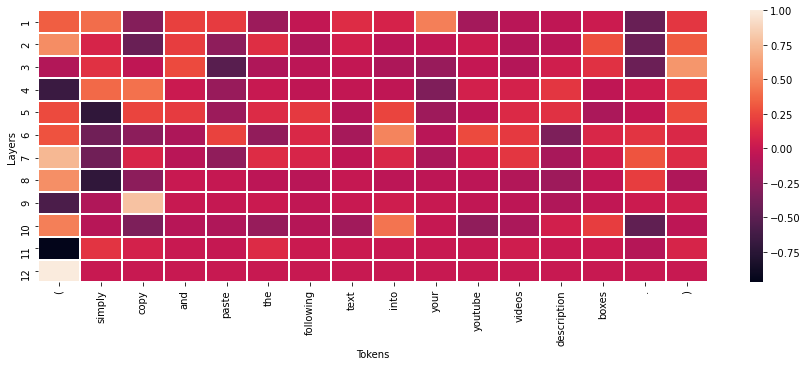

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

Now let's dig deeper into specific tokens and look into the distribution of attributions per layer for the polarizing token '('. The box plot diagram below shows a compressed distribution of attributions with a few large outliers. The polarizing results we see in the heatmap is likely due to the token being characterized by the outliers. 

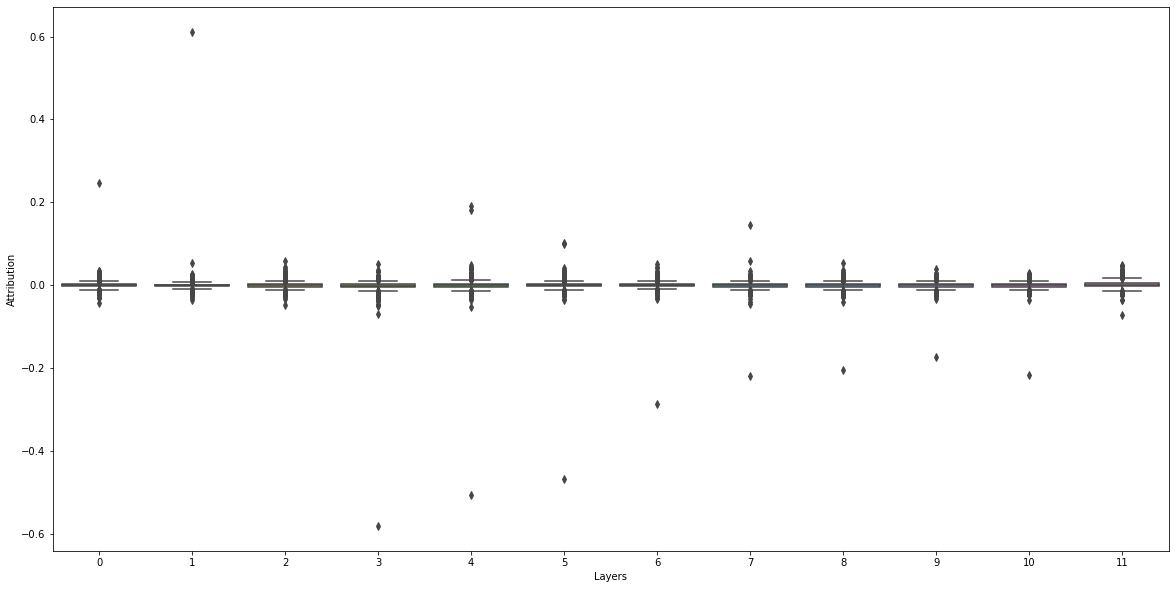

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In addition to that we can also look into the distribution of attributions in each layer for any input token. This will help us to better understand and compare the distributional patterns of attributions across multiple layers. We can for example represent attributions as a probability density function (pdf) and compute the entropy of it in order to estimate the entropy of attributions in each layer. This can be easily computed using a histogram.

In [17]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In this particular case let's compute the pdf for the attributions at token_to_explain.

We will compute and visualize the pdfs and entropies using Shannon's Entropy measure for each layer.

In [18]:
layer_attrs_pdf = map(lambda layer_attrs_dist: pdf_attr(layer_attrs_dist), layer_attrs_dist)
layer_attrs_pdf = np.array(list(layer_attrs_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_dist).sum(-1)

# size: #layers
layer_attrs_pdf_norm = np.linalg.norm(layer_attrs_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_pdf = np.transpose(layer_attrs_pdf)

#size: #bins x #layers
layer_attrs_pdf = np.divide(layer_attrs_pdf, layer_attrs_pdf_norm, where=layer_attrs_pdf_norm!=0)


The plot below visualizes the probability mass function (pmf) of attributions for each layer. From the plot we can observe that the distributions are taking bell-curved shapes with different means gathering around the edges and generally small variances. We can now use attribution pdfs to compute entropies in the next cell.

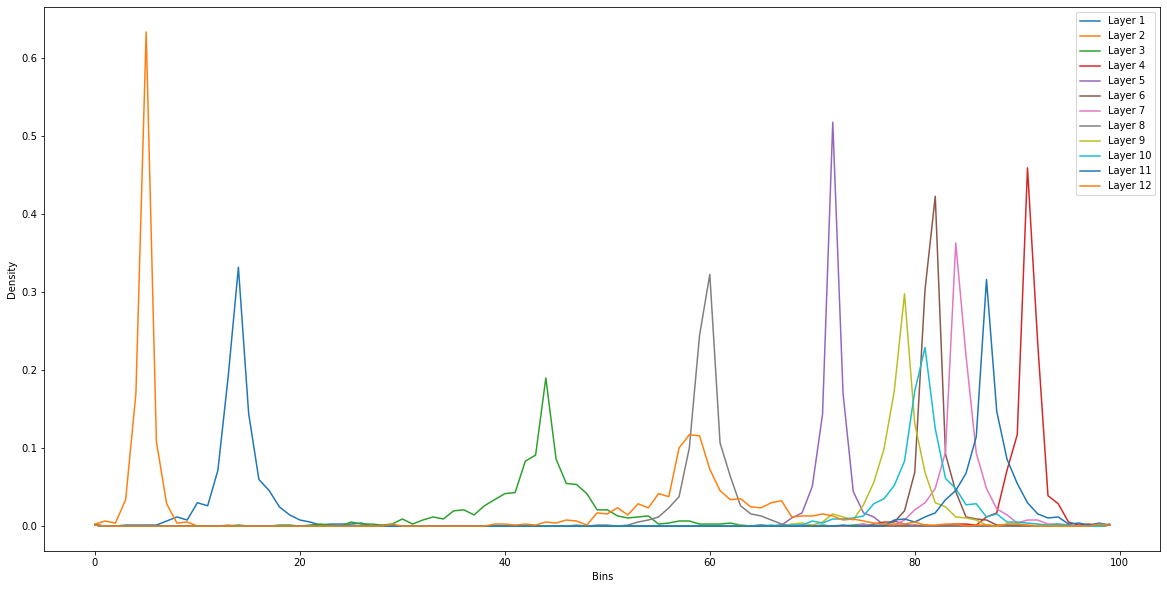

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

Below we calculate and visualize attribution entropies based on Shannon entropy measure where the x-axis corresponds to the number of layers and the y-axis corresponds to the total attribution in that layer. The size of the circles for each (layer, total_attribution) pair correspond to the normalized entropy value at that point.

In this particular example, we observe that layer 3 and 12 have relatively higher entropy. In a general case, entropy can provide us an intuition about the distributional characteristics of attributions in each layer and can be useful especially when comparing it across multiple tokens.

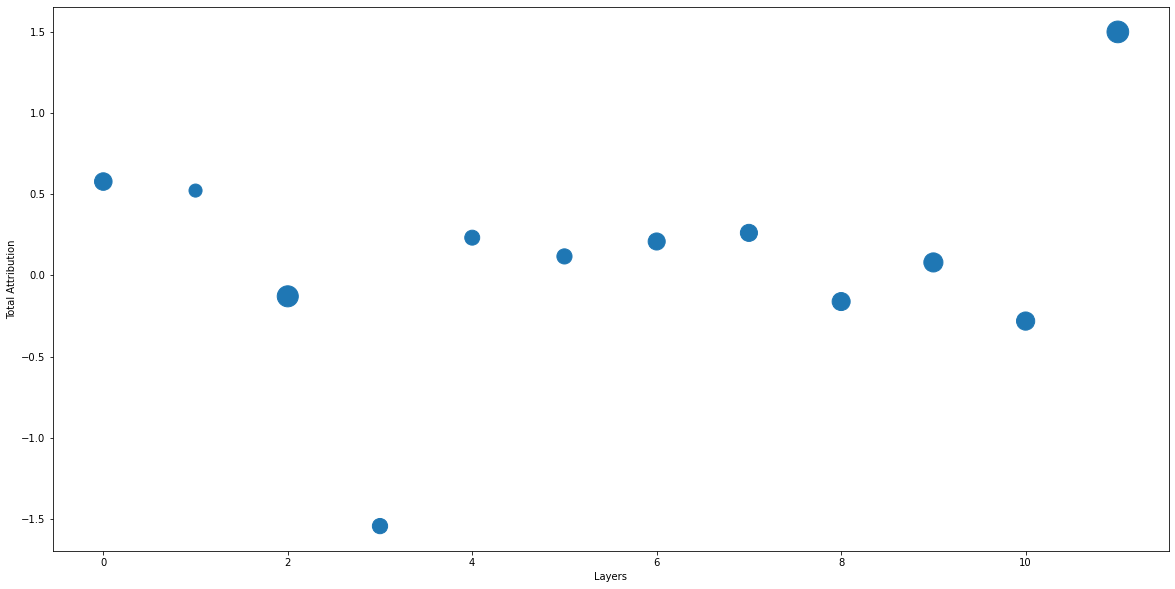

In [20]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_pdf[layer_attrs_pdf == 0] = 1
layer_attrs_pdf_log = np.log2(layer_attrs_pdf)

# size: #layers
entropies= -(layer_attrs_pdf * layer_attrs_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()

In the Part 2 of this tutorial we will to go deeper into attention layers, heads and compare the attributions with the attention weight matrices, study and discuss related statistics.